<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP30_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv',encoding= 'cp949')
df.head()

,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
0,26,1,20.1,81,5.80,4.36,0.86,0.90,2.43,12.0,63.8,5.40
1,40,1,17.7,54,4.60,3.70,1.02,1.50,2.04,9.2,70.3,4.10
2,40,2,19.7,53,5.30,5.87,1.29,1.75,3.37,10.1,61.1,4.85
3,43,1,23.1,71,4.50,4.05,0.74,1.27,2.60,36.5,73.4,5.30
4,36,1,26.5,82,5.54,6.69,3.49,0.91,3.64,69.3,67.5,5.53


In [3]:
df['Gender'] = df['Gender'].astype('str')

In [4]:
df.dtypes

Age         int64
Gender     object
BMI       float64
DBP         int64
FPG       float64
Chol      float64
Tri       float64
HDL       float64
LDL       float64
ALT       float64
CCR       float64
FFPG      float64
dtype: object

In [5]:
df = df.dropna()

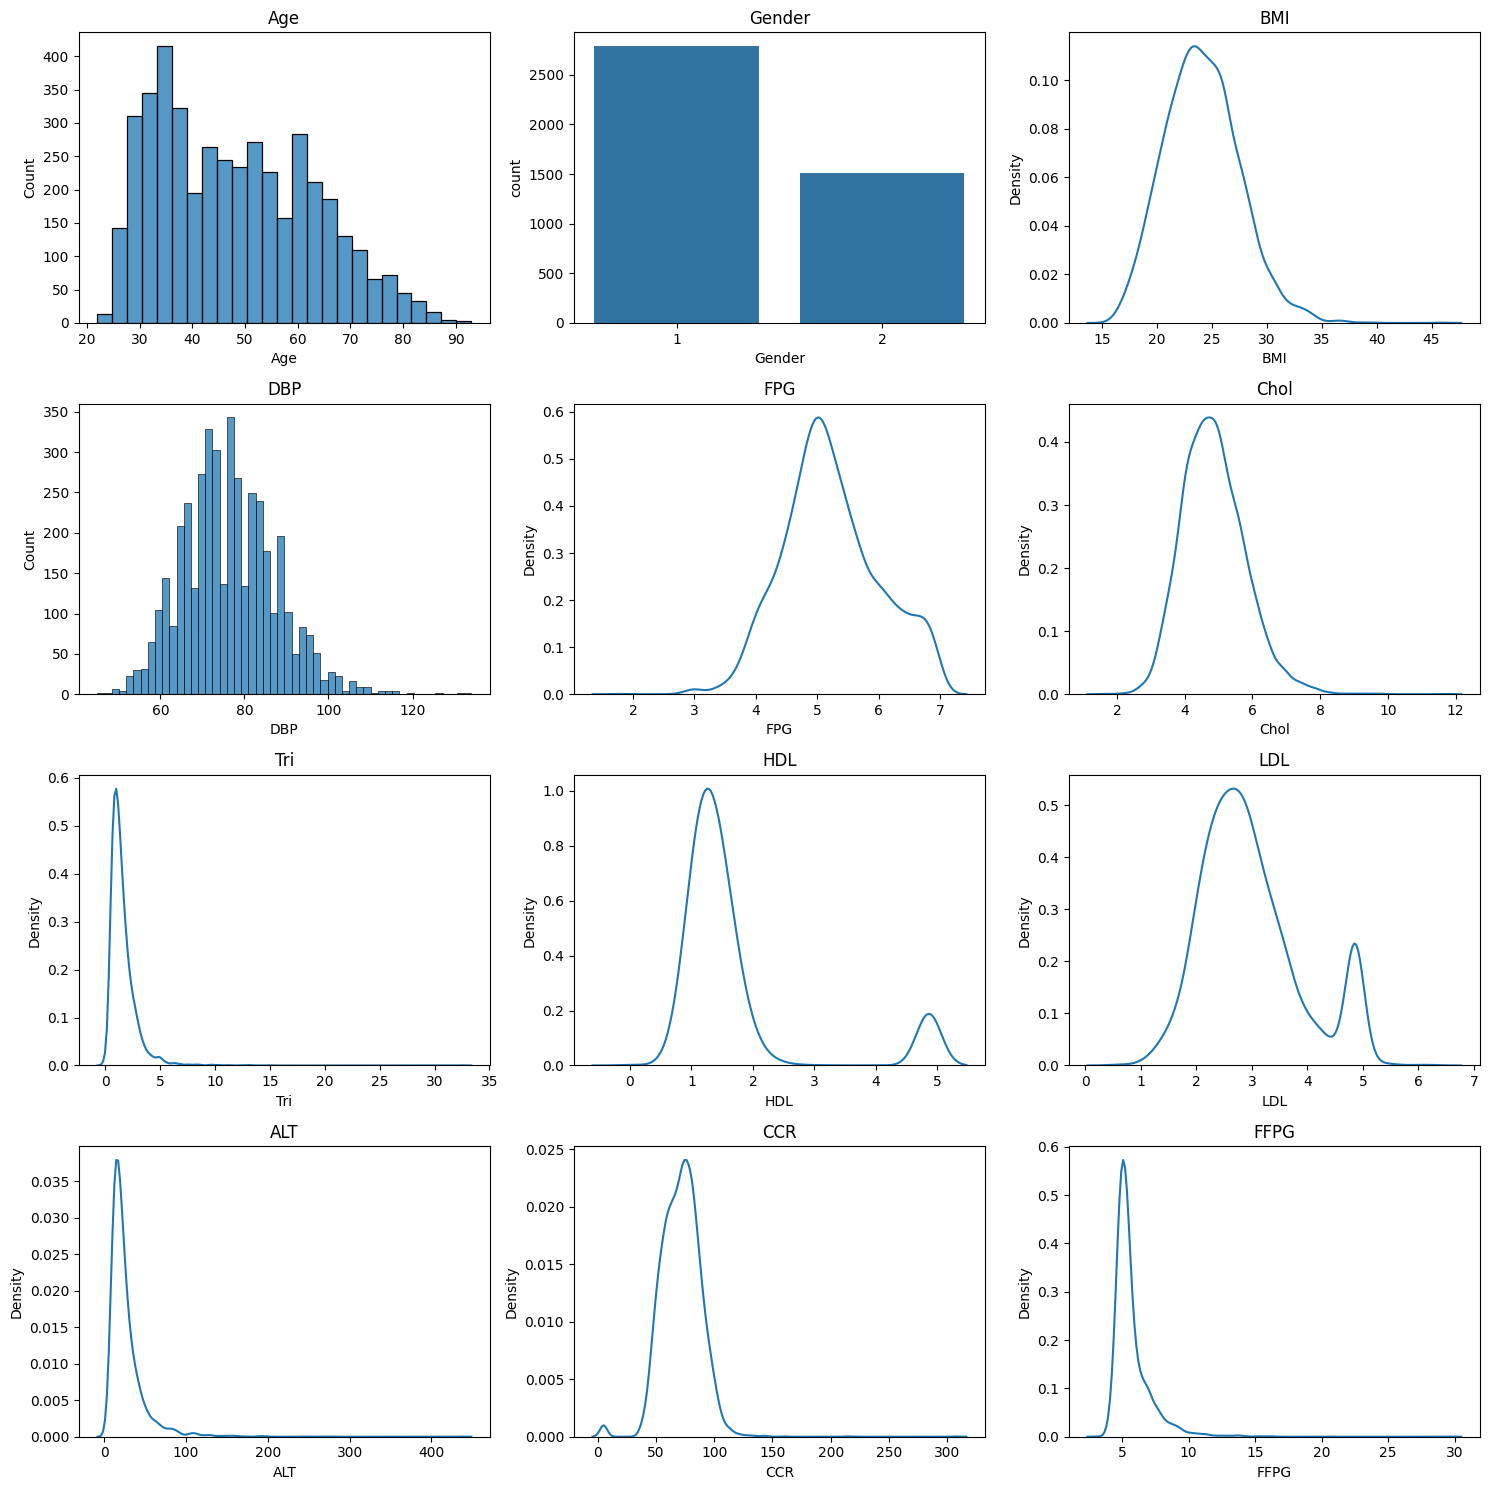

In [6]:

fig, axes = plt.subplots(4,3, figsize = (15,15))

for i, ax in enumerate(axes.flat[:]):
    col = df.columns[i]

    if df[col].dtypes == 'object' :
        target_cnt = df[col].value_counts()
        sns.barplot(x = target_cnt.index, y= target_cnt, ax=ax)

    elif df[col].dtypes== 'int64' :
        sns.histplot(data = df[col], ax=ax)

    else :
        sns.kdeplot(data = df[col], ax=ax)

    ax.set_title(col)


fig.tight_layout()
plt.show()



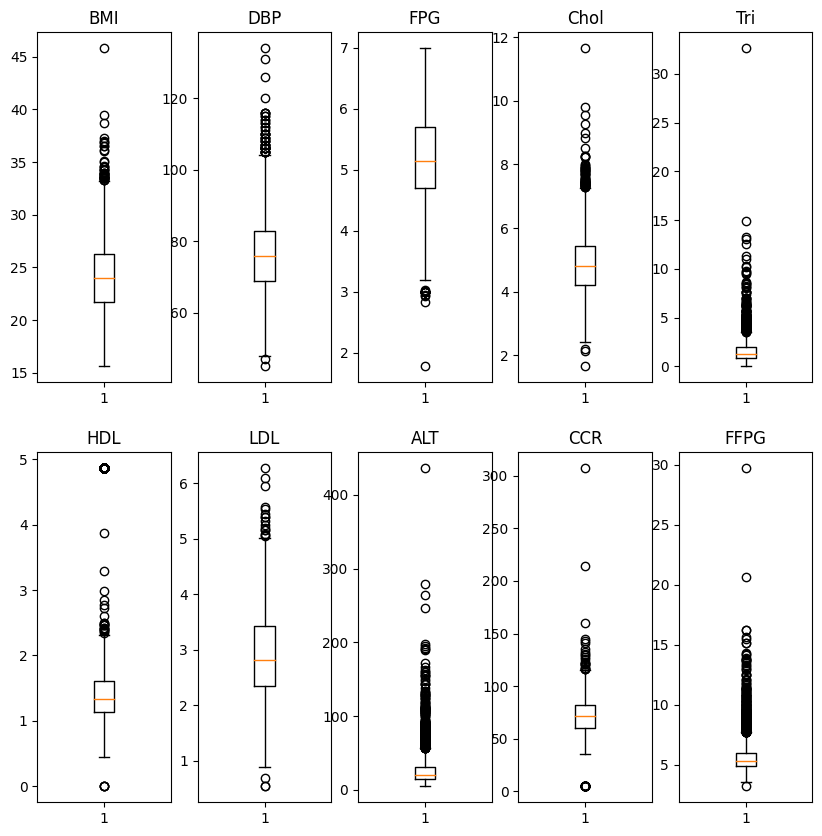

In [7]:
col_name = df.columns[2:]

fig, ax = plt.subplots(2, 5,  figsize = (10, 10))

for i, axes in enumerate(ax.flat[:]) :
  col_i = col_name[i]
  axes.boxplot(df[col_i])
  axes.set_title(col_i)



In [8]:
## 이상치 제거
col_name = df.columns[2:]

def outlier_remove(df) :
  for col in col_name  :
    iqr = np.quantile(df[col], 0.75) - np.quantile(df[col],0.25 )
    upper =  np.quantile(df[col], 0.75) + 1.5 * iqr
    lower =  np.quantile(df[col], 0.75) - 1.5 * iqr

    df = df[(df[col] <=  upper ) & (df[col] >=  lower)]

    return df


df2 = outlier_remove(df)


## 단위 설정을 위한 MinMaxScaler = 분류 모델에 알 맞음

X = df2.drop(columns = 'DBP', axis = 1)
y = df2['DBP']

X.Gender = X.Gender.astype('int')

from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

X = pd.DataFrame(mm.fit_transform(X) , columns = X.columns)



3949 4302
64.24918642491865
27.545327754532778
-0.9805641852375758 0.3268678015286761
귀무가설 채택 즉 유의하지 않다


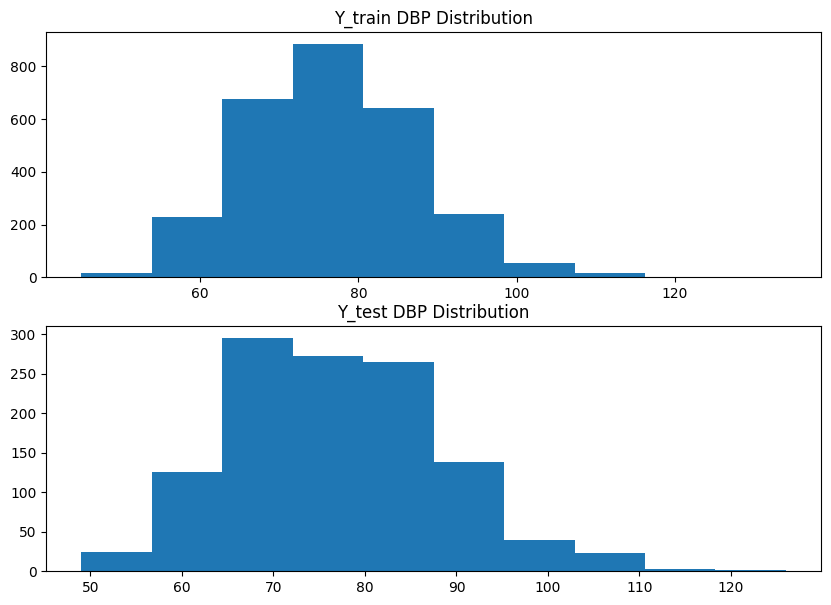

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 1234)

train = x_train.shape[0]
test = x_test.shape[0]
total = df.shape[0]

# 숫자 검정
print(train + test, total)
print(train/total * 100)
print(test/total * 100)


fig, axes = plt.subplots(2, 1, figsize = (10,7))
axes[0].hist(y_train.values)
axes[0].set_title('Y_train DBP Distribution')

axes[1].hist(y_test.values)
axes[1].set_title('Y_test DBP Distribution')


# 통계 검정
# H0 : DBP의 분포는 유의하지 않다.
# H1 : 유의하다
from scipy.stats import ttest_ind

stat, p_val = ttest_ind(y_train, y_test)
print(stat, p_val)
print('귀무가설 기각 즉, 유의하다'  if p_val < 0.05 else  '귀무가설 채택 즉 유의하지 않다')

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
var,0.225958,0.078524,0.044752,0.032873,0.016982,0.015451,0.005038,0.002505,0.002070,0.001982,0.001037
ratio,0.528962,0.183823,0.104764,0.076955,0.039754,0.036171,0.011794,0.005864,0.004845,0.004640,0.002429
cumsum,0.528962,0.712785,0.817548,0.894503,0.934258,0.970429,0.982223,0.988086,0.992931,0.997571,1.000000


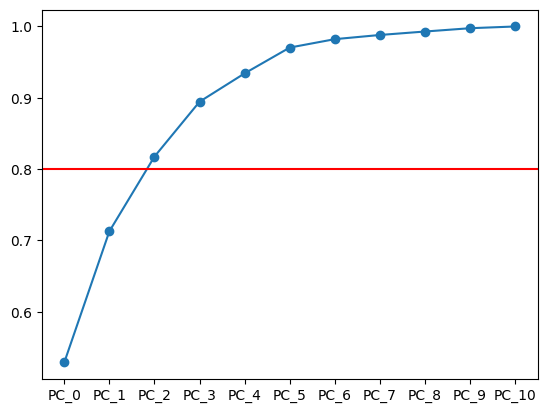

In [10]:
## 차원 축소
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

pca_table = pd.DataFrame(
                          {'var' : pca.explained_variance_,
                            'ratio' : pca.explained_variance_ratio_ })

pca_table.index = ['PC_' + str(i) for i in pca_table.index]
pca_table['cumsum'] = pca_table.ratio.cumsum()

display(pca_table.T)

plt.plot(pca_table['cumsum'],'o-')
plt.axhline(y = 0.8, color ='r')
plt.show()



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     55.98
Date:                Mon, 27 May 2024   Prob (F-statistic):          9.19e-116
Time:                        12:14:48   Log-Likelihood:                -14783.
No. Observations:                3949   AIC:                         2.959e+04
Df Residuals:                    3937   BIC:                         2.967e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.3278      1.267     53.132      0.0

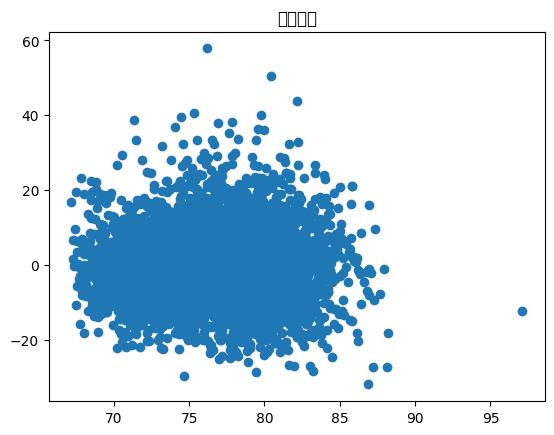

In [11]:
## 선형회귀 모델

import statsmodels.api as sm

X_ = sm.add_constant(X)
model = sm.OLS(np.array(y),np.array(X_)).fit()
print(model.summary())


## 잔차, 피팅값 정의
resid = model.resid
fitted = model.fittedvalues

# 1) 잔차가 정규분포이다.
from statsmodels.stats.stattools import jarque_bera
sttat, p, skwe, kurt = jarque_bera(resid)

# 2) 등분산성 : 잔차의 산포도
plt.scatter(fitted, resid)
plt.title('등분산성')

# 3) 잔차의 독립성 (잔차의 자기 상관성)
from statsmodels.stats.stattools  import durbin_watson
durbin = durbin_watson(resid)
print(durbin)

# 4.선형성 확인
#sns.regplot(fitted, resid, line_kws={'color':'red'})

In [12]:
X = X.drop(columns = ['Age'], axis = 1)

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 1234)
print(x_train.shape)
print(x_test.shape)
print(X.shape)

(3159, 10)
(790, 10)
(3949, 10)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

lr = LinearRegression()
poly = PolynomialFeatures(degree = 2)
la = Lasso()


lr.fit(x_train, y_train)
la.fit(x_train, y_train)

lr_pred = lr.predict(x_test)
la_pred = la.predict(x_test)


## Polynomial 다항회귀
x_poly = poly.fit_transform(x_train)
lr = LinearRegression()
lr.fit(x_poly, y_train)
pred_poly = poly.transform(x_test)
pr_pred = lr.predict(pred_poly)

print('RMSE :', mean_squared_error(y_test, lr_pred))
print('RMSE :', mean_squared_error(y_test, pr_pred, squared = False))
print('RMSE :', mean_squared_error(y_test, la_pred))


RMSE : 107.45166182709636
RMSE : 10.451002262266131
RMSE : 123.12933855211577


In [15]:
# K-Fold 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# K-Fold
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 1234)

# 교차 검증 수행
score = cross_val_score(lr, X, y , scoring = 'neg_mean_squared_error', cv = k_fold)

mse_scores = -score
print(mse_scores)
print(mse_scores.mean())

[107.45166183 114.62488105  94.3807335  110.19564776 109.57304703]
107.24519423317528


In [16]:
kfold = KFold(n_splits = 5)
cv_mse = []

n_iter = 0

for train_idx, test_idx  in kfold.split(X):
  x_train, x_test = X.iloc[train_idx] , X.iloc[test_idx]
  y_train, y_test = y.iloc[train_idx] , y.iloc[test_idx]

  lr.fit(x_train, y_train)
  pred = lr.predict(x_test)

  n_iter += 1

  rmse = round(mean_squared_error(y_test, pred), 2)
  print(f'선형회귀를 이용한 {n_iter}번째 교차검증 결과 rmse ={rmse}')
  cv_mse.append(rmse)


print('평균 RMSE :', np.mean(cv_mse))


선형회귀를 이용한 1번째 교차검증 결과 rmse =97.77
선형회귀를 이용한 2번째 교차검증 결과 rmse =98.46
선형회귀를 이용한 3번째 교차검증 결과 rmse =88.69
선형회귀를 이용한 4번째 교차검증 결과 rmse =109.52
선형회귀를 이용한 5번째 교차검증 결과 rmse =142.31
평균 RMSE : 107.35


In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2_v2.csv')
df.head()

,사고년도,가해자성별,가해자연령,가해차종,가해자신체상해정도,피해자성별,피해자연령,피해차종,피해자신체상해정도,사고유형,가해자법규위반,기상상태,시각,사건번호
0,2015,남,46세,승합차,상해없음,여,64세,자전거,경상,차대차 - 기타,안전운전불이행,맑음,2015-07-03_10시,ID_796
1,2019,남,53세,승용차,상해없음,여,57세,자전거,경상,차대차 - 후진중충돌,안전운전불이행,맑음,2019-10-12_10시,ID_6697
2,2015,남,39세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,기타,맑음,2015-03-23_20시,ID_919
3,2016,남,12세,자전거,상해없음,남,52세,보행자,경상,차대사람 - 길가장자리구역통행중,안전운전불이행,맑음,2016-04-10_15시,ID_2512
4,2015,남,54세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,안전운전불이행,맑음,2015-08-04_6시,ID_75


생시각을 통해 평일인지 주말인지를 구분하는 '주말여부' 범주형 변수 추가하고 데이터 분포

In [18]:
from datetime import datetime

df['시각'] = df['시각'].astype(str)
df['시각'] = pd.to_datetime(df['시각'], format= '%Y-%m-%d_%H시')




In [19]:
df['주말여부'] = df['시각'].dt.day_name().map(lambda x : '주말' if x in ['Saturday', 'Sunday'] else '평일')

<BarContainer object of 2 artists>

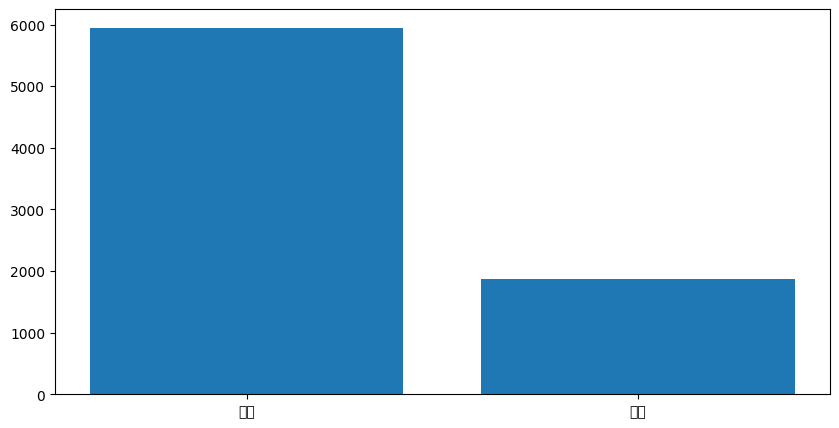

In [20]:
plt.figure(figsize = (10, 5))
plt.bar(x = df['주말여부'].value_counts().index, height = df['주말여부'].value_counts().values)

4-2 '피해자신체상해정도' 에 따라 각 독립변수들이 유의한지 통계적 검정하라

In [24]:
df1 = df.copy()

df1['가해자연령'] = df1['가해자연령'].str.split('세').str[0]
df1['피해자연령'] = df1['피해자연령'].str.split('세').str[0]

df_sorted = df1.drop(columns =['사건번호', '시각'])


## Column 별로 Value_count
for col in df_sorted.columns :
  target_col = df_sorted[col].value_counts()

  print(f"-- {col} --")
  for value, count in target_col.items() :
    print(f"{value} : {count}")






-- 사고년도 --
2015 : 2054
2016 : 1531
2017 : 1238
2019 : 1045
2020 : 1000
2018 : 958
-- 가해자성별 --
남 : 6025
여 : 1801
-- 가해자연령 --
57 : 221
55 : 215
54 : 208
58 : 205
59 : 201
56 : 196
50 : 196
53 : 189
52 : 187
49 : 185
51 : 180
47 : 178
48 : 173
60 : 172
62 : 171
46 : 168
45 : 166
61 : 166
44 : 161
63 : 155
64 : 150
41 : 148
39 : 142
42 : 134
67 : 128
27 : 126
65 : 125
36 : 122
43 : 122
38 : 119
37 : 119
66 : 113
31 : 113
35 : 112
33 : 110
40 : 106
23 : 105
34 : 104
25 : 98
30 : 96
29 : 96
32 : 96
26 : 96
68 : 91
69 : 83
24 : 81
22 : 81
70 : 80
28 : 77
72 : 69
17 : 67
71 : 64
16 : 63
19 : 58
15 : 58
73 : 50
74 : 50
18 : 49
21 : 48
13 : 47
14 : 47
20 : 46
75 : 39
76 : 38
12 : 31
77 : 17
78 : 17
79 : 16
9 : 14
11 : 13
80 : 12
10 : 10
81 : 8
82 : 8
85 : 5
83 : 4
불명 : 3
7 : 2
89 : 1
86 : 1
88 : 1
8 : 1
84 : 1
91 : 1
94 : 1
-- 가해차종 --
승용차 : 4840
자전거 : 1411
화물차 : 713
이륜차 : 355
승합차 : 337
원동기장치자전거 : 120
건설기계 : 27
특수차 : 10
개인형이동수단(PM) : 6
기타 : 3
불명 : 2
농기계 : 1
사륜오토바이(ATV) : 1
-- 가해자신체상해정도 --
상해없음 : 

In [48]:
df3 = df_sorted.copy()
df3 = df3.loc[(df3['가해자연령']!='불명') & (df3['피해자연령'] !='불명') ]


# 피해자신체상해정도에 따른 독립변수들이 유의한지 통계적으로 검정
display(df3['피해자신체상해정도'].value_counts())

y = df3['피해자신체상해정도']
cols = ['사고년도', '가해자성별', '가해자연령', '가해차종', '가해자신체상해정도', '피해자성별', '피해자연령', '피해차종',
        '사고유형', '가해자법규위반', '기상상태', '주말여부']

plst = []
ilst = []
for i in cols :
  if (i == '가해자연령') or (i == '피해자연령') :
    f, p_val = stats.f_oneway(df3.query("피해자신체상해정도 == '경상'")[i] , df3.query("피해자신체상해정도 == '중상'")[i])

  else :
    cross_table = pd.crosstab(df3[i], y)
    chi2, p_val, df, expected = stats.chi2_contingency(cross_table)

    #print(f"{i}와 {p_val}")
    if p_val < 0.05 :
      plst.append(p_val)
      ilst.append(i)


selected_df = pd.DataFrame({
                              "variables": ilst,
                              "p_value": plst
                          })
selected_df

피해자신체상해정도
경상    4678
중상    3145
Name: count, dtype: int64

,variables,p_value
0,가해차종,0.000042
1,가해자신체상해정도,0.036683
2,피해자성별,0.000009
3,피해차종,0.001151
4,사고유형,0.005717
5,가해자법규위반,0.007564


In [62]:
## SMOTE Oversampling 를 수행하고,
# 범주형 변수는 변수별 빈도를 나타내고, 연속형이면 평균을 나타내시오

X = df3[list(selected_df.variables)]
y = df3['피해자신체상해정도'].map(lambda x : 0 if x =='경상' else 1 )


# 범주형 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

for col in X.columns :
  lb = LabelEncoder()
  X[col] = lb.fit_transform(X[col])



,가해차종,가해자신체상해정도,피해자성별,피해차종,사고유형,가해자법규위반
0,6,3,1,6,5,9
1,5,3,1,6,12,9
2,5,3,0,6,5,3
3,9,3,0,2,1,9
4,5,3,0,6,5,9
...,...,...,...,...,...,...
7821,5,3,0,6,7,7
7822,5,3,1,6,11,3
7823,5,3,1,6,11,3
7824,5,3,0,6,5,3


In [72]:
display(y.value_counts())

from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, y)
display(y_smote.value_counts())

피해자신체상해정도
0    4678
1    3145
Name: count, dtype: int64

피해자신체상해정도
0    4678
1    4678
Name: count, dtype: int64

데이터를 가지고 '피해자신체상해정도' 을 종속변수로 하여 로지스틱회귀분석, XGB 분류 분류 모델을 만들고 성능 비교


0.5151407196294977
0.5382971143569647
[0.16727543 0.1333624  0.15182355 0.21940176 0.17359276 0.15454407]


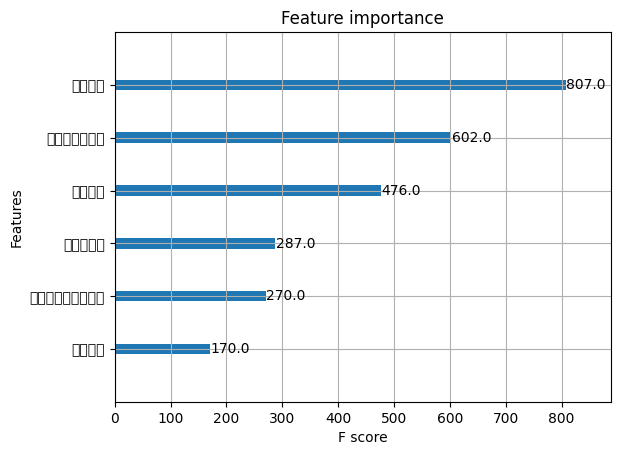

In [74]:
## 나누기
x_train, x_test, y_train, y_test= train_test_split(x_smote, y_smote, test_size = 0.3, random_state = 12234)


from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_score= accuracy_score(y_test, lr_pred)


xgb = xgboost.XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred =  xgb.predict(x_test)
xgb_score = accuracy_score(y_test, xgb_pred)


print(lr_score)
print(xgb_score)


xgboost.plot_importance(xgb)
print(xgb.feature_importances_)

연령대별로 헤드셋 선호도에 차이가 있는지를 검정하기 위한 귀무가설과 연구가설을 설정

In [79]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv')


print(df.나이.value_counts())
print(df.선호도.value_counts())
print()
print('귀무가설 : 연령대별로 헤드셋선호에 대한 차이는 없다')
print('대립가설 : 연령대별로 헤드셋선호에 대한 차이는 있다')
cross = pd.crosstab(df.나이, df.선호도)

chi2, p_val, df, expected = stats.chi2_contingency(cross)
print('귀무가설 기각' if  p_val < 0.05 else '귀무가설 채택')

나이
청년    120
노년     92
장년     65
Name: count, dtype: int64
선호도
1    107
2     99
3     71
Name: count, dtype: int64

귀무가설 : 연령대별로 헤드셋선호에 대한 차이는 없다
대립가설 : 연령대별로 헤드셋선호에 대한 차이는 있다
귀무가설 채택


아이를 6명 가진 가정이 5 가족이고, 아들/딸을 출생할 확률은 0.5

In [85]:
# 딸이 4명 이상인 가구가 3 가족 이상일 확률

from scipy.stats import binom
p = 0.5
n = 6

# 딸이 4명 이상일 확률
d_p = sum(binom.pmf(i, n, p) for i in range(4,7))

sum(binom.pmf(i, n, d_p) for i in range(3,6))

# 5가족 중 몇 가족이 4명 이상의 딸을 가질 것으로 기대하는가
5 * d_p

1.71875